# Import

In [1]:
%load_ext lab_black

In [2]:
# one hot encode runway
# ordinal encode airline
# TODO: Try with avg pb time, ratioH/M, ratio nominal
from traffic.core import Traffic

import pandas as pd
import numpy as np
import pickle

import os.path

from ipyleaflet import Polygon
from ipywidgets import Layout
from ipyleaflet import Map, Marker

import altair as alt

from cartes.osm import Overpass

from sklearn import svm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

from numpy import mean
from numpy import std
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
from ground_analysis.build_features import gather_data

In [4]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
from ground_analysis.extract_flight_info import compute_avg_duration

In [23]:
def compute_avg_duration(
    dep_df,
    dt="30T",
    time_col="on_runway_time",
    on_col="total_holding_time_minutes",
    col_name="avg_delay",
    internal_query=None,
    tolerance=pd.Timedelta("2T"),
):
    # Index is on_runway_time because it makes more sense to compute average
    # ground delays with flights having completed their taxi
    df = dep_df
    if internal_query is not None:
        df = dep_df.query(internal_query)

    avg_delays = (
        df.set_index(time_col)
        .sort_index()[on_col]
        .rolling(
            dt, closed="left"
        )  # closed="left" not needed as it is the target variable
        .agg(["mean", "count"])
        .rename(
            columns={
                "mean": f"{col_name}_mean",
                "count": f"{col_name}_count",
            }
        )
    )
    dep_df = pd.merge_asof(
        dep_df.sort_values(time_col),
        avg_delays,
        left_on=time_col,
        right_index=True,
        tolerance=tolerance,
    )
    return dep_df

# Load

In [24]:
dep_arr_df_12 = pd.read_pickle(
    "../data/processed/dep_arr_df12BIS_onehotconfig_addedsifis_anglesummfixed.pkl"
)

dep_df = dep_arr_df_12.query(
    "mvt_type=='DEP' & (parking_position == parking_position | 1000<taxi_dist)"
)

In [25]:
dep_df_alltrajs = dep_arr_df_12.query("mvt_type=='DEP'")
dep_df_alltrajs = compute_avg_duration(dep_df_alltrajs, col_name="alltrajs_delay_30min")
dep_df = compute_avg_duration(dep_df, col_name="new_avg_delay_30min")
dep_df = compute_avg_duration(
    dep_df,
    dt="30T",
    on_col="taxi_holding_time_minutes",
    col_name="avg_delay_30min",
    internal_query="parking_position==parking_position & mvt_type=='DEP'",
)

In [27]:
dep_df[avg_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12537 entries, 4 to 35528
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   new_avg_delay_30min_mean  12352 non-null  float64
 1   avg_delay_30min_mean      7743 non-null   float64
dtypes: float64(2)
memory usage: 293.8 KB


In [56]:
dep_arr_df_14 = pd.read_pickle(
    "../data/processed/dep_arr_df14_nextavgdelaybetteraffected.pkl"
)
dep_arr_df14.shape

(35517, 121)

In [59]:
dep_arr_df_12 = pd.read_pickle(
    "../data/processed/dep_arr_df12_onehotconfig_addedsifis.pkl"
)
dep_arr_df_12.shape

(35530, 121)

In [63]:
avg_cols = [
    "avg_delay_30min",
    "avg_delay_30min_all_trajs",
]
datachart = dep_arr_df_12.query("mvt_type=='DEP'")[avg_cols]

avg_delay_30min_chart = (
    alt.Chart(datachart.dropna())
    .transform_density("avg_delay_30min", extent=[0, 15])
    .mark_line(color="red")
    .encode(alt.X("value:Q"), alt.Y("density:Q"))
)
avg_delay_30min_all_trajs_chart = (
    alt.Chart(datachart.dropna())
    .transform_density("avg_delay_30min_all_trajs", extent=[0, 15])
    .mark_line(color="green")
    .encode(alt.X("value:Q"), alt.Y("density:Q"))
)

datachart = dep_arr_df_14.query("mvt_type=='DEP'")[avg_cols]

new_avg_delay_30min_chart = (
    alt.Chart(datachart.dropna())
    .transform_density("avg_delay_30min", extent=[0, 15])
    .mark_line(color="blue")
    .encode(alt.X("value:Q", title="Additional TXOT (min)"), alt.Y("density:Q"))
)
(avg_delay_30min_chart + avg_delay_30min_all_trajs_chart + new_avg_delay_30min_chart)

alt.LayerChart(...)

In [36]:
dt_between_f = (
    dep_df.query('mvt_type=="DEP" & 6<=hh_num<=22')
    .sort_values("first_movement_start")["first_movement_start"]
    .diff()
    .dt.total_seconds()
    / 60
)
dt_between_f_fulltrajs = (
    dep_df.query('mvt_type=="DEP" & 6<=hh_num<=22 & parking_position==parking_position')
    .sort_values("first_movement_start")["first_movement_start"]
    .diff()
    .dt.total_seconds()
    / 60
)

In [45]:
dt_between_f.describe()

count    11451.000000
mean         7.628031
std         37.136550
min          0.000000
25%          1.316667
50%          3.000000
75%          6.166667
max        572.116667
Name: first_movement_start, dtype: float64

In [46]:
dt_between_f_fulltrajs.describe()

count    6583.000000
mean       13.268811
std        49.307805
min         0.000000
25%         2.200000
50%         5.400000
75%        11.416667
max       587.566667
Name: first_movement_start, dtype: float64

<AxesSubplot:>

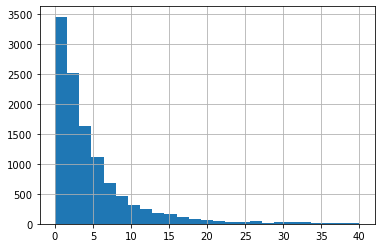

In [44]:
dt_between_f.hist(range=(0, 40), bins=25)

<AxesSubplot:>

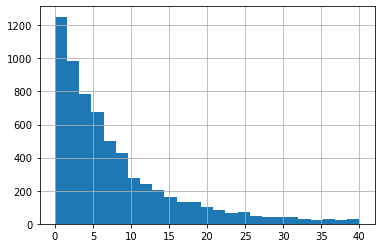

In [43]:
dt_between_f_fulltrajs.hist(range=(0, 40), bins=25)